In [53]:
import pandas as pd
import numpy as np

import yfinance as yf
import tushare as ts
from stockstats import StockDataFrame as Sdf
import stockstats

from tqdm import tqdm
import requests
from datetime import datetime, timedelta

import matplotlib.pyplot as plt

import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from neofinrl_config.py)
        end_date : str
            end date of the data (modified from neofinrl_config.py)
        ticker_list : list
            a list of stock tickers (modified from neofinrl_config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API

    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------

        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        num_failures = 0
        for tic in self.ticker_list:
            temp_df = yf.download(
                tic, start=self.start_date, end=self.end_date, proxy=proxy
            )
            temp_df["tic"] = tic
            if len(temp_df) > 0:
                # data_df = data_df.append(temp_df)
                data_df = pd.concat([data_df, temp_df], axis=0)
            else:
                num_failures += 1
        if num_failures == len(self.ticker_list):
            raise ValueError("no data is fetched.")
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()
        try:
            # convert the column names to standardized names
            data_df.columns = [
                "date",
                "open",
                "high",
                "low",
                "close",
                "adjcp",
                "volume",
                "tic",
            ]
            # use adjusted close price instead of close price
            data_df["close"] = data_df["adjcp"]
            # drop the adjusted close price column
            data_df = data_df.drop(labels="adjcp", axis=1)
        except NotImplementedError:
            print("the features are not supported currently")
        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)

        return data_df

    def select_equal_rows_stock(self, df):
        df_check = df.tic.value_counts()
        df_check = pd.DataFrame(df_check).reset_index()
        df_check.columns = ["tic", "counts"]
        mean_df = df_check.counts.mean()
        equal_list = list(df.tic.value_counts() >= mean_df)
        names = df.tic.value_counts().index
        select_stocks_list = list(names[equal_list])
        df = df[df.tic.isin(select_stocks_list)]
        return df

In [4]:
DATA_SAVE_DIR = "datasets"
TRAINED_MODEL_DIR = "trained_models"
TENSORBOARD_LOG_DIR = "tensorboard_log"
RESULTS_DIR = "results"

# date format: '%Y-%m-%d'
TRAIN_START_DATE = "2014-01-06"  # bug fix: set Monday right, start date set 2014-01-01 ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 1658 and the array at index 1 has size 1657
TRAIN_END_DATE = "2020-07-31"

TEST_START_DATE = "2020-08-01"
TEST_END_DATE = "2021-10-01"

TRADE_START_DATE = "2021-11-01"
TRADE_END_DATE = "2021-12-01"

# stockstats technical indicator column names
# check https://pypi.org/project/stockstats/ for different names
INDICATORS = [
    "macd",
    "boll_ub",
    "boll_lb",
    "rsi_30",
    "cci_30",
    "dx_30",
    "close_30_sma",
    "close_60_sma",
]


# Model Parameters
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.01, "learning_rate": 0.0007}
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 64,
}
DDPG_PARAMS = {"batch_size": 128, "buffer_size": 50000, "learning_rate": 0.001}
TD3_PARAMS = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.001}
SAC_PARAMS = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
ERL_PARAMS = {
    "learning_rate": 3e-5,
    "batch_size": 2048,
    "gamma": 0.985,
    "seed": 312,
    "net_dimension": 512,
    "target_step": 5000,
    "eval_gap": 30,
    "eval_times": 64,  # bug fix:KeyError: 'eval_times' line 68, in get_model model.eval_times = model_kwargs["eval_times"]
}
RLlib_PARAMS = {"lr": 5e-5, "train_batch_size": 500, "gamma": 0.99}


# Possible time zones
TIME_ZONE_SHANGHAI = "Asia/Shanghai"  # Hang Seng HSI, SSE, CSI
TIME_ZONE_USEASTERN = "US/Eastern"  # Dow, Nasdaq, SP
TIME_ZONE_PARIS = "Europe/Paris"  # CAC,
TIME_ZONE_BERLIN = "Europe/Berlin"  # DAX, TECDAX, MDAX, SDAX
TIME_ZONE_JAKARTA = "Asia/Jakarta"  # LQ45
TIME_ZONE_SELFDEFINED = "xxx"  # If neither of the above is your time zone, you should define it, and set USE_TIME_ZONE_SELFDEFINED 1.
USE_TIME_ZONE_SELFDEFINED = 0  # 0 (default) or 1 (use the self defined)

# parameters for data sources
ALPACA_API_KEY = "xxx"  # your ALPACA_API_KEY
ALPACA_API_SECRET = "xxx"  # your ALPACA_API_SECRET
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"  # alpaca url
BINANCE_BASE_URL = "https://data.binance.vision/"  # binance url


In [5]:
def load_dataset(*, file_name: str) -> pd.DataFrame:
    """
    load csv dataset from path
    :return: (df) pandas dataframe
    """
    # _data = pd.read_csv(f"{config.DATASET_DIR}/{file_name}")
    _data = pd.read_csv(file_name)
    return _data


def data_split(df, start, end, target_date_col="date"):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data


def convert_to_datetime(time):
    time_fmt = "%Y-%m-%dT%H:%M:%S"
    if isinstance(time, str):
        return datetime.datetime.strptime(time, time_fmt)


class FeatureEngineer:
    """Provides methods for preprocessing the stock price data

    Attributes
    ----------
        use_technical_indicator : boolean
            we technical indicator or not
        tech_indicator_list : list
            a list of technical indicator names (modified from neofinrl_config.py)
        use_turbulence : boolean
            use turbulence index or not
        user_defined_feature:boolean
            use user defined features or not

    Methods
    -------
    preprocess_data()
        main method to do the feature engineering

    """

    def __init__(
        self,
        use_technical_indicator=True,
        tech_indicator_list=INDICATORS,
        use_vix=False,
        use_turbulence=False,
        user_defined_feature=False,
    ):
        self.use_technical_indicator = use_technical_indicator
        self.tech_indicator_list = tech_indicator_list
        self.use_vix = use_vix
        self.use_turbulence = use_turbulence
        self.user_defined_feature = user_defined_feature

    def preprocess_data(self, df):
        """main method to do the feature engineering
        @:param config: source dataframe
        @:return: a DataMatrices object
        """
        # clean data
        df = self.clean_data(df)

        # add technical indicators using stockstats
        if self.use_technical_indicator:
            df = self.add_technical_indicator(df)
            print("Successfully added technical indicators")

        # add vix for multiple stock
        if self.use_vix:
            df = self.add_vix(df)
            print("Successfully added vix")

        # add turbulence index for multiple stock
        if self.use_turbulence:
            df = self.add_turbulence(df)
            print("Successfully added turbulence index")

        # add user defined feature
        if self.user_defined_feature:
            df = self.add_user_defined_feature(df)
            print("Successfully added user defined features")

        # fill the missing values at the beginning and the end
        df = df.fillna(method="ffill").fillna(method="bfill")
        return df

    def clean_data(self, data):
        """
        clean the raw data
        deal with missing values
        reasons: stocks could be delisted, not incorporated at the time step
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(["date", "tic"], ignore_index=True)
        df.index = df.date.factorize()[0]
        merged_closes = df.pivot_table(index="date", columns="tic", values="close")
        merged_closes = merged_closes.dropna(axis=1)
        tics = merged_closes.columns
        df = df[df.tic.isin(tics)]
        # df = data.copy()
        # list_ticker = df["tic"].unique().tolist()
        # only apply to daily level data, need to fix for minute level
        # list_date = list(pd.date_range(df['date'].min(),df['date'].max()).astype(str))
        # combination = list(itertools.product(list_date,list_ticker))

        # df_full = pd.DataFrame(combination,columns=["date","tic"]).merge(df,on=["date","tic"],how="left")
        # df_full = df_full[df_full['date'].isin(df['date'])]
        # df_full = df_full.sort_values(['date','tic'])
        # df_full = df_full.fillna(0)
        return df

    def add_technical_indicator(self, data):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(by=["tic", "date"])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()

        for indicator in self.tech_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator["tic"] = unique_ticker[i]
                    temp_indicator["date"] = df[df.tic == unique_ticker[i]][
                        "date"
                    ].to_list()
                    # indicator_df = indicator_df.append(
                    #     temp_indicator, ignore_index=True
                    # )
                    indicator_df = pd.concat(
                        [indicator_df, temp_indicator], axis=0, ignore_index=True
                    )
                except Exception as e:
                    print(e)
            df = df.merge(
                indicator_df[["tic", "date", indicator]], on=["tic", "date"], how="left"
            )
        df = df.sort_values(by=["date", "tic"])
        return df
        # df = data.set_index(['date','tic']).sort_index()
        # df = df.join(df.groupby(level=0, group_keys=False).apply(lambda x, y: Sdf.retype(x)[y], y=self.tech_indicator_list))
        # return df.reset_index()

    def add_user_defined_feature(self, data):
        """
         add user defined features
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df["daily_return"] = df.close.pct_change(1)
        # df['return_lag_1']=df.close.pct_change(2)
        # df['return_lag_2']=df.close.pct_change(3)
        # df['return_lag_3']=df.close.pct_change(4)
        # df['return_lag_4']=df.close.pct_change(5)
        return df

    def add_vix(self, data):
        """
        add vix from yahoo finance
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df_vix = YahooDownloader(
            start_date=df.date.min(), end_date=df.date.max(), ticker_list=["^VIX"]
        ).fetch_data()
        vix = df_vix[["date", "close"]]
        vix.columns = ["date", "vix"]

        df = df.merge(vix, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    def add_turbulence(self, data):
        """
        add turbulence index from a precalcualted dataframe
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        turbulence_index = self.calculate_turbulence(df)
        df = df.merge(turbulence_index, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    def calculate_turbulence(self, data):
        """calculate turbulence index based on dow 30"""
        # can add other market assets
        df = data.copy()
        df_price_pivot = df.pivot(index="date", columns="tic", values="close")
        # use returns to calculate turbulence
        df_price_pivot = df_price_pivot.pct_change()

        unique_date = df.date.unique()
        # start after a year
        start = 252
        turbulence_index = [0] * start
        # turbulence_index = [0]
        count = 0
        for i in range(start, len(unique_date)):
            current_price = df_price_pivot[df_price_pivot.index == unique_date[i]]
            # use one year rolling window to calcualte covariance
            hist_price = df_price_pivot[
                (df_price_pivot.index < unique_date[i])
                & (df_price_pivot.index >= unique_date[i - 252])
            ]
            # Drop tickers which has number missing values more than the "oldest" ticker
            filtered_hist_price = hist_price.iloc[
                hist_price.isna().sum().min() :
            ].dropna(axis=1)

            cov_temp = filtered_hist_price.cov()
            current_temp = current_price[[x for x in filtered_hist_price]] - np.mean(
                filtered_hist_price, axis=0
            )
            # cov_temp = hist_price.cov()
            # current_temp=(current_price - np.mean(hist_price,axis=0))

            temp = current_temp.values.dot(np.linalg.pinv(cov_temp)).dot(
                current_temp.values.T
            )
            if temp > 0:
                count += 1
                if count > 2:
                    turbulence_temp = temp[0][0]
                else:
                    # avoid large outlier because of the calculation just begins
                    turbulence_temp = 0
            else:
                turbulence_temp = 0
            turbulence_index.append(turbulence_temp)
        try:
            turbulence_index = pd.DataFrame(
                {"date": df_price_pivot.index, "turbulence": turbulence_index}
            )
        except ValueError:
            raise Exception("Turbulence information could not be added.")
        return turbulence_index


In [6]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-06-01'

df = YahooDownloader(
    start_date = TRAIN_START_DATE,
    end_date = TRADE_END_DATE,
    ticker_list = ["AAPL", "NVDA", "ENPH"]
).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (9560, 8)


In [7]:
df

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.496295,493729600,AAPL,0
1,2010-01-04,4.627500,4.655000,4.527500,4.241150,80020400,NVDA,0
2,2010-01-05,7.664286,7.699643,7.616071,6.507526,601904800,AAPL,1
3,2010-01-05,4.605000,4.740000,4.605000,4.303082,72864800,NVDA,1
4,2010-01-06,7.656429,7.686786,7.526786,6.404016,552160000,AAPL,2
...,...,...,...,...,...,...,...,...
9555,2023-05-30,167.720001,175.809998,167.300003,174.119995,4056600,ENPH,1
9556,2023-05-30,405.950012,419.380005,399.489990,401.068481,92340100,NVDA,1
9557,2023-05-31,177.330002,179.350006,176.759995,177.250000,99625300,AAPL,2
9558,2023-05-31,173.850006,176.220001,169.300003,173.880005,3659000,ENPH,2


In [8]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3374, 8)
Successfully added vix
Successfully added turbulence index


In [9]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,7.622500,7.660714,7.585000,6.496295,493729600,AAPL,0,0.000000,6.517793,6.486028,100.000000,66.666667,100.000000,6.496295,6.496295,20.040001,0.000000
1,2010-01-04,4.627500,4.655000,4.527500,4.241150,80020400,NVDA,0,0.000000,6.517793,6.486028,100.000000,66.666667,100.000000,4.241150,4.241150,20.040001,0.000000
2,2010-01-05,7.664286,7.699643,7.616071,6.507526,601904800,AAPL,1,0.000252,6.517793,6.486028,100.000000,66.666667,100.000000,6.501911,6.501911,19.350000,0.000000
3,2010-01-05,4.605000,4.740000,4.605000,4.303082,72864800,NVDA,1,0.001389,4.359700,4.184532,100.000000,66.666667,100.000000,4.272116,4.272116,19.350000,0.000000
4,2010-01-06,7.656429,7.686786,7.526786,6.404016,552160000,AAPL,2,-0.002889,6.582875,6.355684,9.492434,-100.000000,40.699144,6.469279,6.469279,19.160000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6743,2023-05-25,385.230011,394.799988,366.350006,379.760681,154391100,NVDA,3,15.891414,343.131820,250.912705,75.137050,420.002617,60.160017,288.354160,272.797601,19.139999,83.211663
6744,2023-05-26,173.320007,175.770004,173.110001,175.429993,54835000,AAPL,4,2.298691,177.290853,166.811775,61.894732,97.834370,24.985389,170.022689,164.016899,17.950001,0.466989
6745,2023-05-26,378.899994,391.700012,375.500000,389.419678,71439700,NVDA,4,20.863313,363.537468,241.702897,76.218244,334.215505,60.160017,292.416405,275.403324,17.950001,0.466989
6746,2023-05-30,176.960007,178.990005,176.570007,177.300003,55964400,AAPL,1,2.478154,178.021539,166.875514,63.425989,146.888126,30.386517,170.432630,164.458209,17.459999,0.468310


In [10]:
# stock_bac = yf.Ticker("BAC")
# stock_bac.get_financials() # Doesn't work -- consider using https://pypi.org/project/yahooquery/1.1.0/

In [11]:
#Alpha Vantage Token: BMUKDHLNVBEVBUKT

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key

API_KEY = "BMUKDHLNVBEVBUKT"

In [132]:
def get_fundamental_data(function, symbol, key):
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&apikey={key}'
    r = requests.get(url)
    data = r.json()

    return data

def get_treasury_data(interval, maturity, key):
    url = f'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval={interval}&maturity={maturity}&apikey={key}'
    r = requests.get(url)
    data = r.json()

    return data

def get_time_series_data(symbol, interval, key, function="TIME_SERIES_INTRADAY"):
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&interval={interval}&apikey={key}&outputsize=full'
    r = requests.get(url)
    data = r.json()

    return data

In [135]:
# get_fundamental_data(function="NEWS_SENTIMENT", symbol="NVDA", key=key)
treasury_data = get_treasury_data("daily","7year", API_KEY)

In [137]:
treasury_data['data']

[{'date': '2023-07-14', 'value': '3.94'},
 {'date': '2023-07-13', 'value': '3.85'},
 {'date': '2023-07-12', 'value': '3.97'},
 {'date': '2023-07-11', 'value': '4.13'},
 {'date': '2023-07-10', 'value': '4.14'},
 {'date': '2023-07-07', 'value': '4.23'},
 {'date': '2023-07-06', 'value': '4.22'},
 {'date': '2023-07-05', 'value': '4.11'},
 {'date': '2023-07-04', 'value': '.'},
 {'date': '2023-07-03', 'value': '4.03'},
 {'date': '2023-06-30', 'value': '3.97'},
 {'date': '2023-06-29', 'value': '3.99'},
 {'date': '2023-06-28', 'value': '3.83'},
 {'date': '2023-06-27', 'value': '3.90'},
 {'date': '2023-06-26', 'value': '3.85'},
 {'date': '2023-06-23', 'value': '3.88'},
 {'date': '2023-06-22', 'value': '3.92'},
 {'date': '2023-06-21', 'value': '3.84'},
 {'date': '2023-06-20', 'value': '3.85'},
 {'date': '2023-06-19', 'value': '.'},
 {'date': '2023-06-16', 'value': '3.88'},
 {'date': '2023-06-15', 'value': '3.82'},
 {'date': '2023-06-14', 'value': '3.95'},
 {'date': '2023-06-13', 'value': '3.94'}

In [51]:
treasury_df = pd.DataFrame(treasury_data['data'])
treasury_df = treasury_df.rename(columns={"value": "7year_rate"})
treasury_df["date"] = pd.to_datetime(treasury_df["date"])

In [133]:
earnings = get_fundamental_data(
    function="EARNINGS",
    symbol="NVDA",
    key=API_KEY,
)

In [134]:
earnings

{'symbol': 'NVDA',
 'annualEarnings': [{'fiscalDateEnding': '2023-04-30', 'reportedEPS': '1.09'},
  {'fiscalDateEnding': '2023-01-31', 'reportedEPS': '3.33'},
  {'fiscalDateEnding': '2022-01-31', 'reportedEPS': '4.45'},
  {'fiscalDateEnding': '2021-01-31', 'reportedEPS': '2.51'},
  {'fiscalDateEnding': '2020-01-31', 'reportedEPS': '1.45'},
  {'fiscalDateEnding': '2019-01-31', 'reportedEPS': '1.66'},
  {'fiscalDateEnding': '2018-01-31', 'reportedEPS': '1.15'},
  {'fiscalDateEnding': '2017-01-31', 'reportedEPS': '0.64'},
  {'fiscalDateEnding': '2016-01-31', 'reportedEPS': '0.3'},
  {'fiscalDateEnding': '2015-01-31', 'reportedEPS': '0.28'},
  {'fiscalDateEnding': '2014-01-31', 'reportedEPS': '0.18'},
  {'fiscalDateEnding': '2013-01-31', 'reportedEPS': '0.24'},
  {'fiscalDateEnding': '2012-01-31', 'reportedEPS': '0.24'},
  {'fiscalDateEnding': '2011-01-31', 'reportedEPS': '0.17'},
  {'fiscalDateEnding': '2010-01-31', 'reportedEPS': '0.11'},
  {'fiscalDateEnding': '2009-01-31', 'reportedEPS

In [50]:
earnings_df = pd.DataFrame(earnings["quarterlyEarnings"])
earnings_df["tic"] = "NVDA"
earnings_df = earnings_df.rename(columns={"reportedDate": "date"})
earnings_df = earnings_df.drop(["fiscalDateEnding", "surprise"], axis=1)
earnings_df["date"] = pd.to_datetime(earnings_df["date"])

In [150]:
balance_sheet = get_fundamental_data(
    function="INCOME_STATEMENT",
    symbol="NVDA",
    key=API_KEY,
)
balance_sheet

{'symbol': 'NVDA',
 'annualReports': [{'fiscalDateEnding': '2023-01-29',
   'reportedCurrency': 'USD',
   'grossProfit': '15356000000',
   'totalRevenue': '26974000000',
   'costOfRevenue': '11618000000',
   'costofGoodsAndServicesSold': '1040000000',
   'operatingIncome': '4224000000',
   'sellingGeneralAndAdministrative': '2440000000',
   'researchAndDevelopment': '7339000000',
   'operatingExpenses': '11132000000',
   'investmentIncomeNet': '267000000',
   'netInterestIncome': '-262000000',
   'interestIncome': '267000000',
   'interestExpense': '262000000',
   'nonInterestIncome': 'None',
   'otherNonOperatingIncome': '-48000000',
   'depreciation': '844000000',
   'depreciationAndAmortization': '699000000',
   'incomeBeforeTax': '4181000000',
   'incomeTaxExpense': '-187000000',
   'interestAndDebtExpense': '262000000',
   'netIncomeFromContinuingOperations': '4368000000',
   'comprehensiveIncomeNetOfTax': '4336000000',
   'ebit': '4443000000',
   'ebitda': '5142000000',
   'netIn

In [100]:
balance_sheet_df = pd.DataFrame(balance_sheet['quarterlyReports'])
balance_sheet_df["tic"] = "NVDA"
balance_sheet_df = balance_sheet_df.rename(columns={"fiscalDateEnding": "date"})
balance_sheet_df = balance_sheet_df.drop(["reportedCurrency"], axis=1)
balance_sheet_df["date"] = pd.to_datetime(balance_sheet_df["date"]) + timedelta(1)

In [101]:
balance_sheet_df

,date,grossProfit,totalRevenue,costOfRevenue,costofGoodsAndServicesSold,operatingIncome,sellingGeneralAndAdministrative,researchAndDevelopment,operatingExpenses,investmentIncomeNet,...,depreciationAndAmortization,incomeBeforeTax,incomeTaxExpense,interestAndDebtExpense,netIncomeFromContinuingOperations,comprehensiveIncomeNetOfTax,ebit,ebitda,netIncome,tic
0,2023-05-01,4648000000,7192000000,2544000000,2544000000,2140000000,633000000,1875000000,2508000000,150000000,...,181000000,2209000000,166000000,66000000,2043000000,2036000000,2275000000,2456000000,2043000000,NVDA
1,2023-01-30,3833000000,6051000000,2218000000,2218000000,1256000000,625000000,1952000000,2577000000,115000000,...,556000000,1288000000,-126000000,64000000,1414000000,1494000000,1352000000,1908000000,1414000000,NVDA
2,2022-10-31,3177000000,5931000000,2754000000,2754000000,601000000,631000000,1945000000,2576000000,88000000,...,181000000,613000000,-67000000,65000000,680000000,647000000,678000000,859000000,680000000,NVDA
3,2022-08-01,2915000000,6704000000,3789000000,570000000,499000000,592000000,1824000000,2416000000,46000000,...,182000000,475000000,-181000000,65000000,656000000,630000000,540000000,722000000,656000000,NVDA
4,2022-05-02,5431000000,8288000000,2857000000,2857000000,1868000000,592000000,1618000000,3563000000,18000000,...,155000000,1805000000,187000000,68000000,1618000000,1565000000,1873000000,2027000000,1618000000,NVDA
5,2022-01-31,4999000000,7643000000,2644000000,2644000000,2970000000,563000000,1466000000,2029000000,9000000,...,145000000,2865000000,-138000000,61000000,3003000000,2983000000,2926000000,3071000000,3003000000,NVDA
6,2021-11-01,4631000000,7103000000,2472000000,2472000000,2671000000,557000000,1403000000,1960000000,7000000,...,143000000,2638000000,174000000,62000000,2464000000,2465000000,2700000000,2843000000,2464000000,NVDA
7,2021-08-02,4215000000,6507000000,2292000000,2292000000,2444000000,526000000,1245000000,1771000000,6000000,...,286000000,2394000000,20000000,60000000,252000000,2368000000,2454000000,2740000000,2374000000,NVDA
8,2021-05-03,3629000000,5661000000,2032000000,2032000000,1956000000,520000000,1153000000,1673000000,6000000,...,281000000,2044000000,132000000,53000000,1912000000,1907000000,2097000000,2378000000,1912000000,NVDA
9,2021-02-01,3156000000,5003000000,1847000000,1846000000,1507000000,503000000,1146000000,1649000000,7000000,...,288000000,1470000000,13000000,53000000,1457000000,1464000000,1523000000,1811000000,1457000000,NVDA


In [59]:
nvda_df = processed[processed["tic"] == "NVDA"]
nvda_df["date"] = pd.to_datetime(nvda_df["date"])
nvda_df = nvda_df.merge(earnings_df, how="left", on=["date", "tic"]).fillna(method="ffill")
# nvda_df = nvda_df.merge(balance_sheet_df, how="left", on=["date", "tic"]).fillna(method="ffill")
nvda_df = nvda_df.merge(treasury_df, how="left", on="date").fillna(method="ffill")

/var/folders/6y/6p7qrh9s27d1s3l8p2l81vbw0000gn/T/ipykernel_49305/2278417920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_df["date"] = pd.to_datetime(nvda_df["date"])


In [60]:
nvda_df.isna().sum()

date                   0
open                   0
high                   0
low                    0
close                  0
volume                 0
tic                    0
day                    0
macd                   0
boll_ub                0
boll_lb                0
rsi_30                 0
cci_30                 0
dx_30                  0
close_30_sma           0
close_60_sma           0
vix                    0
turbulence             0
reportedEPS           30
estimatedEPS          30
surprisePercentage    30
7year_rate             0
dtype: int64

In [61]:
nvda_df

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,reportedEPS,estimatedEPS,surprisePercentage,7year_rate
0,2010-01-04,4.627500,4.655000,4.527500,4.241150,80020400,NVDA,0,0.000000,6.517793,...,66.666667,100.000000,4.241150,4.241150,20.040001,0.000000,NaN,NaN,NaN,3.36
1,2010-01-05,4.605000,4.740000,4.605000,4.303082,72864800,NVDA,1,0.001389,4.359700,...,66.666667,100.000000,4.272116,4.272116,19.350000,0.000000,NaN,NaN,NaN,3.28
2,2010-01-06,4.687500,4.730000,4.642500,4.330607,64916800,NVDA,2,0.002624,4.383248,...,66.380342,100.000000,4.291613,4.291613,19.160000,0.000000,NaN,NaN,NaN,3.33
3,2010-01-07,4.695000,4.715000,4.592500,4.245737,54779200,NVDA,3,0.000057,4.367909,...,-20.505229,22.736860,4.280144,4.280144,19.059999,0.000000,NaN,NaN,NaN,3.33
4,2010-01-08,4.590000,4.670000,4.562500,4.254912,47816800,NVDA,4,-0.000974,4.354384,...,-56.065023,1.001513,4.275098,4.275098,18.129999,0.000000,NaN,NaN,NaN,3.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369,2023-05-23,310.000000,312.880005,306.309998,306.848236,35625300,NVDA,1,10.584999,317.103742,...,152.678384,40.443180,283.168031,269.029358,18.530001,0.665675,0.88,0.81,8.642,3.73
3370,2023-05-24,302.100006,306.070007,298.059998,305.348419,72141900,NVDA,2,10.297778,317.962636,...,111.836777,31.298732,284.515558,270.250223,20.030001,0.111082,1.09,0.92,18.4783,3.76
3371,2023-05-25,385.230011,394.799988,366.350006,379.760681,154391100,NVDA,3,15.891414,343.131820,...,420.002617,60.160017,288.354160,272.797601,19.139999,83.211663,1.09,0.92,18.4783,3.86
3372,2023-05-26,378.899994,391.700012,375.500000,389.419678,71439700,NVDA,4,20.863313,363.537468,...,334.215505,60.160017,292.416405,275.403324,17.950001,0.466989,1.09,0.92,18.4783,3.86


In [78]:
# ts_data = get_time_series_data(symbol="NVDA", interval="30min", key=API_KEY, function="TIME_SERIES_INTRADAY")
# pd.DataFrame(ts_data["Time Series (30min)"]).T

In [3]:
# df = pd.read_csv("/Users/taylorlast/OMSCS/DL/CS7643-Deep-RL-for-Finance/data/baseline_data_large_cap_no_fundamentals.csv", index_col="Unnamed: 0")

# df = pd.read_csv("/Users/taylorlast/OMSCS/DL/CS7643-Deep-RL-for-Finance/data/train_NVDA_no_fundamentals.csv", index_col="Unnamed: 0")


df = pd.read_csv("/Users/taylorlast/OMSCS/DL/CS7643-Deep-RL-for-Finance//data/train_large_cap_no_fundamentals.csv",index_col="Unnamed: 0")

In [7]:
df["vix"]

0       11.000000
1       11.130000
2       10.860000
3       10.940000
4       11.200000
          ...    
3913    17.580000
3914    19.360001
3915    18.309999
3916    17.700001
3917    18.240000
Name: vix, Length: 3918, dtype: float64

In [61]:
df.index = df.reset_index()["index"] - df.reset_index()["index"].min()

In [62]:
df.groupby("tic").count()

,date,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,2year_rate,10year_rate,30year_rate
tic,,,,,,,,,,,,,,,,,,,,
AAL,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918
AAPL,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918
INTC,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918
NVDA,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918,3918


In [73]:
df.replace('.',np.nan).ffill()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,...,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,2year_rate,10year_rate,30year_rate
index,,,,,,,,,,,,,,,,,,,,,
0,2006-01-06,39.709999,39.709999,38.139999,36.766914,349200,AAL,4,0.000000,37.103031,...,0.000000,-66.666667,100.000000,36.766914,36.766914,11.000000,0.000000,4.36,4.38,4.53
0,2006-01-06,2.687500,2.739286,2.662500,2.316094,704457600,AAPL,4,0.000000,37.103031,...,0.000000,-66.666667,100.000000,2.316094,2.316094,11.000000,0.000000,4.36,4.38,4.53
0,2006-01-06,26.480000,26.629999,26.209999,15.724622,45703200,INTC,4,0.000000,37.103031,...,0.000000,-66.666667,100.000000,15.724622,15.724622,11.000000,0.000000,4.36,4.38,4.53
0,2006-01-06,3.386667,3.415833,3.254167,3.122563,62338800,NVDA,4,0.000000,37.103031,...,0.000000,-66.666667,100.000000,3.122563,3.122563,11.000000,0.000000,4.36,4.38,4.53
1,2006-01-09,38.799999,38.880001,38.500000,36.399258,220800,AAL,0,-0.008249,37.103031,...,0.000000,-66.666667,100.000000,36.583086,36.583086,11.130000,0.000000,4.36,4.38,4.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3916,2021-07-29,195.190002,198.529999,193.279999,196.323959,19078100,NVDA,3,2.338056,209.934608,...,58.936614,15.983440,14.359925,194.703827,176.130560,17.700001,1.042590,0.20,1.28,1.91
3917,2021-07-30,20.840000,21.150000,20.240000,20.379999,31284000,AAL,4,-0.199376,22.230138,...,45.481868,-60.664292,10.840100,21.153000,22.161833,18.240000,1.969764,0.19,1.24,1.89
3917,2021-07-30,144.380005,146.330002,144.110001,144.170517,70440600,AAPL,4,2.878398,148.558657,...,59.620985,49.090871,12.975855,140.123288,132.678366,18.240000,1.969764,0.19,1.24,1.89


In [30]:
# np.append((df.loc[1, :].close.values - df.loc[0, :].close.values)/df.loc[0, :].close.values, 0)

In [37]:
df.loc[[1]]

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
1,2014-01-07,4.01,4.05,3.9825,3.807411,33328800,NVDA,1,0.001376,3.863483,3.690006,100.0,66.666667,100.0,3.776745,3.776745,12.92,0.0


In [31]:
df.loc[0:6].close.diff()*50000

0            NaN
1    3066.670895
2    2594.912052
3   -7194.948196
4    -235.950947
5   -4364.073277
6    5661.582947
Name: close, dtype: float64

In [36]:
df.loc[0:6].close.pct_change()*50000

0            NaN
1     818.635085
2     681.542328
3   -1864.309632
4     -63.506020
5   -1176.080807
6    1562.501234
Name: close, dtype: float64

In [8]:
torch.load_state_dict("/Users/taylorlast/OMSCS/DL/CS7643-Deep-RL-for-Finance/trained_models/DQN.pt")

AttributeError: module 'torch' has no attribute 'load_state_dict'

In [2]:
model_state_dict= torch.load("/Users/taylorlast/OMSCS/DL/CS7643-Deep-RL-for-Finance/trained_models/DQN.pt")
# model = DQN(env, 64)
# model.load_state_dict(model_state_dict)
model_state_dict

OrderedDict([('network_stack.0.weight',
              tensor([[ 9.0900e-02,  5.5339e-02, -2.1445e-01,  1.0131e-01,  1.8560e-01,
                       -2.9558e-01, -1.8414e-01, -1.1316e-01,  1.1238e+00, -6.3463e-01],
                      [-3.9039e-01,  2.9577e-01, -1.7133e-01, -1.0743e-01,  1.2250e-01,
                       -2.8015e-01, -2.6950e-02,  2.5835e-01,  6.8319e-01,  3.8832e-01],
                      [-1.4536e-01,  6.3644e-02, -9.2274e-02,  7.2457e-02,  5.7273e-02,
                       -1.9653e-01,  1.3839e-01,  1.4223e-02,  1.2414e+00, -5.1495e-01],
                      [ 3.3888e-01,  1.2489e-01, -1.9194e-01, -2.8932e-01, -2.2558e-02,
                       -2.6474e-02,  1.8823e-01, -5.0302e-03,  9.1346e-01, -3.5653e-01],
                      [ 5.6323e-01, -4.6074e-02,  2.3609e-01, -3.1284e-01, -7.3559e-03,
                        1.7543e-01,  4.7942e-03,  2.3975e-04, -8.8826e-01,  1.9363e-01],
                      [-4.3708e-01,  2.0022e-01, -3.8464e-02, -1.5478e-01, 

In [12]:
a = np.array([[1,2],[3,4]])

In [30]:
np.hstack((a, np.zeros(a.shape[1]).reshape(-1,1)))

array([[1., 2., 0.],
       [3., 4., 0.]])

In [32]:
torch.tensor(([[1,2],[3,4]])).numpy()

array([[1, 2],
       [3, 4]])

In [33]:
5e-4

0.0005

In [34]:
1e-5

1e-05

In [43]:
df = pd.read_csv("/Users/taylorlast/OMSCS/DL/CS7643-Deep-RL-for-Finance/results/simple_stock_env/archive/portfolio_value_train_128hidden_layer.csv")
df_2 = pd.read_csv("/Users/taylorlast/OMSCS/DL/CS7643-Deep-RL-for-Finance/results/simple_stock_env/archive/portfolio_value_train_256_hidden_layer.csv")


In [49]:
df.columns = ["ind", "value"]
df_2.columns = ["ind", "value"]

In [51]:
comb_df = df.merge(df_2, on="ind")

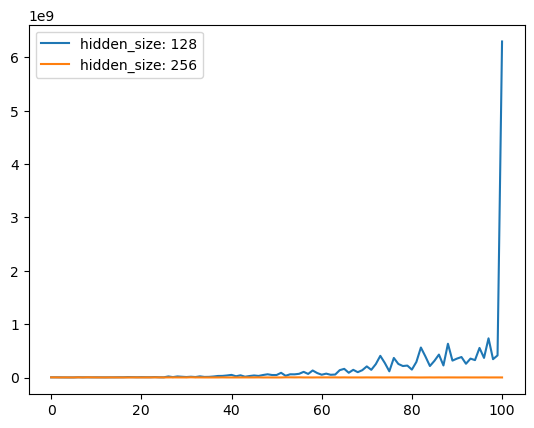

In [61]:
plt.figure()
plt.plot(df["value"], label="hidden_size: 128")
plt.plot(df_2["value"], label="hidden_size: 256")
plt.legend()
plt.savefig("/Users/taylorlast/OMSCS/DL/CS7643-Deep-RL-for-Finance/results/hidden_size_comparison.png")